In [1]:
import numpy as np
import pandas as pd
import scipy.stats

pd.options.mode.chained_assignment = None
from matplotlib import pyplot as plt, rcParams
# import cv2
import seaborn as sns

sns.set(style="white", context="paper")
from cycler import cycler
import os, sys
import glob
from datetime import datetime, timedelta
from itertools import combinations
import base64
from PIL import Image
from io import BytesIO as _BytesIO
import requests
import json
import pickle
from datetime import datetime
from IPython.display import display, Markdown, Latex
from sklearn.metrics import *
import collections
from copy import deepcopy
import traceback
from sympy import Point, Polygon
import mmcv
import cv2
from mmtrack.apis import inference_mot, init_model as init_tracking_model
from smartprint import smartprint as sprint

pd.options.display.max_columns = None
def printm(s): return display(Markdown(s))
    
SERVER_CACHE_DIR = '/mnt/ci-nas-cache/edulyzeV2/cache_compute_4/fixed_face'
os.makedirs(SERVER_CACHE_DIR,exist_ok=True)

track_analysis_meta_cache = f'{SERVER_CACHE_DIR}/analysis_tracking/meta_info'
os.makedirs(track_analysis_meta_cache,exist_ok=True)
base_dir = '/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face'

track_analysis_session_data = f'{SERVER_CACHE_DIR}/analysis_tracking/session_tracking_info'
os.makedirs(track_analysis_session_data,exist_ok=True)

postprocessed_id_map_data_dir = f'{SERVER_CACHE_DIR}/analysis_tracking/processed_id_maps'
os.makedirs(postprocessed_id_map_data_dir, exist_ok=True)

id_viz_cache_root = f'{SERVER_CACHE_DIR}/analysis_tracking/session_matching_info'
os.makedirs(id_viz_cache_root, exist_ok=True)


/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/prasoon/anaconda3/envs/edusense/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Postprocess mmtrack results and create a new tracking map from older tracking ids

In [20]:
session_id = 'classinsight-cmu_05748A_ghc_4101_201902051630-front'
course = '05748A'

session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
session_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/{course}/{session_id}'
df_tracking = pickle.load(open(session_tracking_cache_file,"rb")).transpose()

In [21]:
df_tracking.shape

(11922, 1417)

In [61]:
printm(f'## Raw tracking shape:{df_tracking.shape}')
printm(f'## Filter non-persistentids')
MIN_ID_FRAMES = 900 # number of frames an id needs to be a persistent id
col_start_stop_idxs = []
for col in df_tracking.columns:
    one_idxs = df_tracking.index[np.where(df_tracking[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']

total_idxs = df_tracking.index.max()

# _ = plt.figure(figsize=(20,15))
# for row_idx, row in df_id_start_stop.iterrows():
#     plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
# plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
# plt.grid()

## Raw tracking shape:(11922, 1417)

## Filter non-persistentids

In [62]:
total_idxs, np.arange(0,1.1,1/4)

(71526, array([0.  , 0.25, 0.5 , 0.75, 1.  ]))

In [63]:
nonpersistent_ids_removed = df_id_start_stop[df_id_start_stop.total_idxs<=MIN_ID_FRAMES].sort_values(by=['total_idxs'], ascending=False)['id'].values
print(nonpersistent_ids_removed[:10])
printm(f'### Total ids before filtering: {df_id_start_stop.shape[0]}')

[1320  302  941  331  831   76  566  471 1236  646]


### Total ids before filtering: 1417

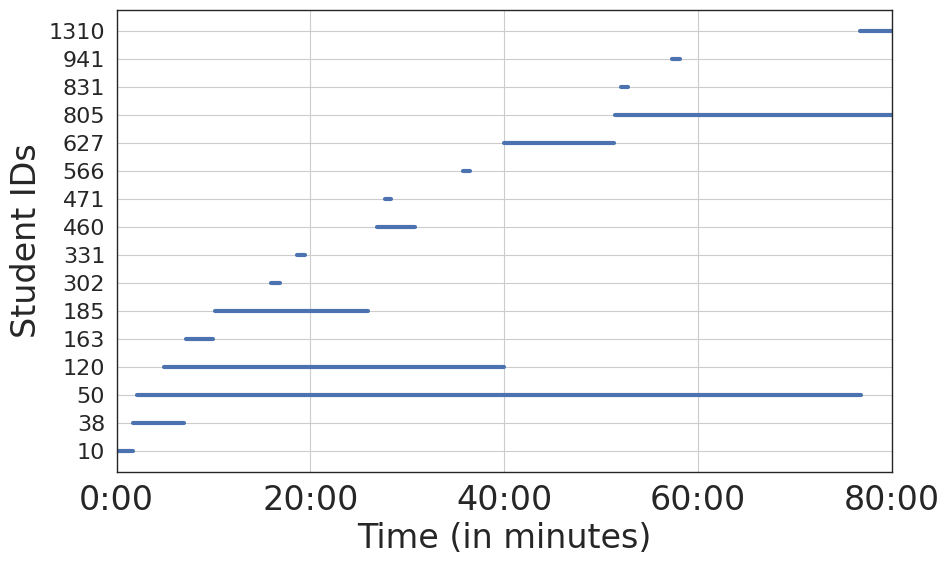

In [64]:
selected_filtered_ids = [302,941,331,831,566,471]
selected_mapped_ids = [10,38, 163,185, 460, 50, 1310, 120, 627, 627, 805]
all_selected_ids = selected_filtered_ids + selected_mapped_ids
total_idxs = df_tracking.index.max()
df_id_start_stop = df_id_start_stop[(df_id_start_stop['id'].isin(all_selected_ids))].reset_index(drop=True)
_ = plt.figure(figsize=(10,6))
y_tick_labels= []
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs, linewidth=3)
    y_tick_labels.append(row['id'])
plt.yticks(range(df_id_start_stop.shape[0]), y_tick_labels, fontsize=16)
plt.xticks(np.arange(0,1.1,1/4), [f'{xr}:00' for xr in [0,20,40,60,80]], fontsize=24)
plt.xlabel("Time (in minutes)", fontsize=24)
plt.ylabel("Student IDs", fontsize=24)
plt.grid()
plt.savefig('plots/local_reconcilition_temporal_v2.png', bbox_inches='tight', dpi=250)

In [18]:
# selected_filtered_ids = deepcopy(nonpersistent_ids_removed)
# selected_filtered_ids
# array([560, 312, 257, 589, 442, 156, 594, 148, 512, 725, 359, 162, 767,
#        313, 732])
# selected_mapped_ids = [0,40, 328, 15, 155, 43, 105, 44, 246, 97, 142]

In [ ]:
{0: 0, 1: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 14: 7, 15: 8, 24: 9, 38: 10, 43: 11, 44: 12, 48: 13, 68: 14, 88: 15, 97: 16, 99: 17, 108: 18, 129: 19, 145: 20, 153: 21, 165: 22, 198: 23, 205: 24, 255: 25, 293: 26, 323: 27, 418: 28, 438: 29, 469: 30, 529: 31, 542: 32, 709: 33, 851: 34, 897: 35, 926: 36}

In [48]:
df_id_start_stop = df_id_start_stop[df_id_start_stop.total_idxs>MIN_ID_FRAMES].reset_index(drop=True)
printm(f'### Total ids after filtering: {df_id_start_stop.shape[0]}')

### Total ids after filtering: 50

In [49]:
printm(f'## Map ids into one based on bbox overlap and id start/stop distance')
MAX_ID_DISTANCE = 900
MAX_BBOX_OVERLAP = 0.4
bbox_dict = {}
potential_id_maps = {}
num_possible_maps = 0 
for row_idx, row in df_id_start_stop.iterrows():
    row_maxidx = row['max_idx']
    
    # get polygon for given id
    id_max_frame = row_maxidx
    id_frame_data = pickle.load(open(f"{session_frame_dir}/{id_max_frame}.pb","rb"))[1]
    id_frame_data = [xr for xr in id_frame_data if (xr['track_id']==row['id'])][0]
    id_bb = id_frame_data['bbox'][:4].astype(int)
    X_TL1, Y_TL1, X_BR1, Y_BR1 = id_bb
    p1, p2, p3, p4  = map(Point, [[X_TL1,Y_TL1], [X_TL1,Y_BR1], [X_BR1,Y_BR1],[X_BR1, Y_TL1]]) 
    id_polygon = Polygon(p1, p2, p3, p4)
    
    potential_id_matches = df_id_start_stop[(df_id_start_stop.min_idx<=row_maxidx+MAX_ID_DISTANCE) & (df_id_start_stop.min_idx>row_maxidx-MAX_ID_DISTANCE)].id.values
    successful_matches = []
    if len(potential_id_matches)>0:
        num_possible_maps+=1
        # print('\n',row['id'], potential_id_matches, row['min_idx'],row['max_idx'],row['total_idxs'])
        for matched_id in potential_id_matches:
            matched_id_min_frame = df_id_start_stop[df_id_start_stop.id==matched_id].min_idx.values[0]
            matched_id_frame_data = pickle.load(open(f"{session_frame_dir}/{matched_id_min_frame}.pb","rb"))[1]
            matched_id_frame_data = [xr for xr in matched_id_frame_data if (xr['track_id']==matched_id)][0]
            matched_id_bb = matched_id_frame_data['bbox'][:4].astype(int)
            X_TL2, Y_TL2, X_BR2, Y_BR2 = matched_id_bb
            
            p1, p2, p3, p4  = map(Point, [[X_TL2,Y_TL2], [X_TL2,Y_BR2], [X_BR2,Y_BR2],[X_BR2, Y_TL2]]) 
            matched_id_polygon = Polygon(p1, p2, p3, p4)
            
            #find intersection of two polygons
            # check if intersection exists
            if id_polygon.encloses_point(matched_id_polygon.centroid) & matched_id_polygon.encloses_point(id_polygon.centroid):
                X_TL_in, X_BR_in = sorted([X_TL1,X_TL2, X_BR1, X_BR2])[1:3]
                Y_TL_in, Y_BR_in = sorted([Y_TL1,Y_TL2, Y_BR1, Y_BR2])[1:3]
                p1, p2, p3, p4  = map(Point, [[X_TL_in,Y_TL_in], [X_TL_in,Y_BR_in], [X_BR_in,Y_BR_in],[X_BR_in, Y_TL_in]]) 
                intersection = Polygon(p1, p2, p3, p4)            

                #find polygon overlap
                area_intersection = np.abs(intersection.area)
                area_union = np.abs(id_polygon.area) + np.abs(matched_id_polygon.area) - area_intersection
                overlap_fraction  = (area_intersection/area_union).evalf()
            else:
                overlap_fraction=0.            
            if overlap_fraction > MAX_BBOX_OVERLAP:
                bbox_dict[(row['id'],matched_id)] = [id_bb, matched_id_bb]
                successful_matches.append((matched_id, overlap_fraction))
            
            # print('\tMatching Id: ', matched_id,':', 'frame:',matched_id_min_frame,'overlap_fraction:', overlap_fraction)
    if len(successful_matches) > 0:
        successful_matched_id = sorted(successful_matches, key=lambda x: x[1])[-1][0]
        print(row['id'], '-->Successful match to-->',successful_matched_id)
        if row['id'] in potential_id_maps.keys():
            potential_id_maps[successful_matched_id] = potential_id_maps[row['id']]
        else:
            potential_id_maps[successful_matched_id] = row['id']

matched_ids  = list(potential_id_maps.keys())
df_id_start_stop =  df_id_start_stop[~df_id_start_stop['id'].isin(matched_ids)].sort_values(by='id').reset_index(drop=True)
printm(f'### Total ids after mapping: {df_id_start_stop.shape[0]}')

printm(f'## Assign new ids to final set of postprocessed ids')
new_to_old_id_map = df_id_start_stop['id'].to_dict()
old_to_new_id_map = {v: k for k, v in new_to_old_id_map.items()}

for matched_id in matched_ids:
    old_to_new_id_map[matched_id] = old_to_new_id_map[potential_id_maps[matched_id]]
    
print(potential_id_maps)
for removed_id in nonpersistent_ids_removed:
    old_to_new_id_map[removed_id] = 10000
        

## Map ids into one based on bbox overlap and id start/stop distance

10 -->Successful match to--> 38
38 -->Successful match to--> 163
50 -->Successful match to--> 1310
120 -->Successful match to--> 627
163 -->Successful match to--> 185
185 -->Successful match to--> 460
627 -->Successful match to--> 805
649 -->Successful match to--> 692
692 -->Successful match to--> 713
713 -->Successful match to--> 758
758 -->Successful match to--> 821
821 -->Successful match to--> 1006
1092 -->Successful match to--> 1162
1162 -->Successful match to--> 1220
1220 -->Successful match to--> 1287


### Total ids after mapping: 35

## Assign new ids to final set of postprocessed ids

{38: 10, 163: 10, 1310: 50, 627: 120, 185: 10, 460: 10, 805: 120, 692: 649, 713: 649, 758: 649, 821: 649, 1006: 649, 1162: 1092, 1220: 1092, 1287: 1092}


In [71]:

# [0, 40, 15, 155, 43, 105, 44, 246, 97, 142]
manual_bboxes = {
    (10,38): ([2203,  445, 2504,  888], [2133,  451, 2490,  868]),
    (38,163): ([2145,  462, 2498,  862], [2141,  458, 2498,  857]),
    (163,185): ([2148,  462, 2500,  979], [2188,  455, 2517,  932]),
    (185, 460): ([2216,  451, 2512,  889], [2151,  454, 2494,  904]),
    (0, 40): ([1036,  249, 1391,  767], [1034,  271, 1295,  728]),
    # (15, 155): ([2553,  351, 2876,  806], [2615,  335, 2886,  818]),
    (120, 627):([2684,  449, 2945,  955], [2579,  463, 2956, 1028]),
    (627, 805): ([2605,  451, 2908, 1008], [2590,  453, 2902,  998]),
}

In [70]:
# [50, 1310, 120, 627, 805]
# [10,38, 163,185, 460, 50, 1310, 120, 627, 627, 805]
bbox_dict[(185, 460)]

[array([2216,  451, 2512,  889]), array([2151,  454, 2494,  904])]

In [118]:
# plot manual bboxes on image
# video_from_session = 'classinsight-cmu_05748A_ghc_4101_201901311630-front'
video_from_session = 'classinsight-cmu_05748A_ghc_4101_201902051630-front'

session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{video_from_session.split("-front")[0]}/{video_from_session}.avi'
frame_video = mmcv.VideoReader(session_video_file)[24000]
frame_video.shape


[h264 @ 0x8f07880] error while decoding MB 195 125, bytestream -5
[h264 @ 0x9e2a400] error while decoding MB 87 58, bytestream -5
[h264 @ 0x87e13c0] error while decoding MB 195 125, bytestream -5


(2160, 3840, 3)

In [119]:
type(frame_video)

numpy.ndarray

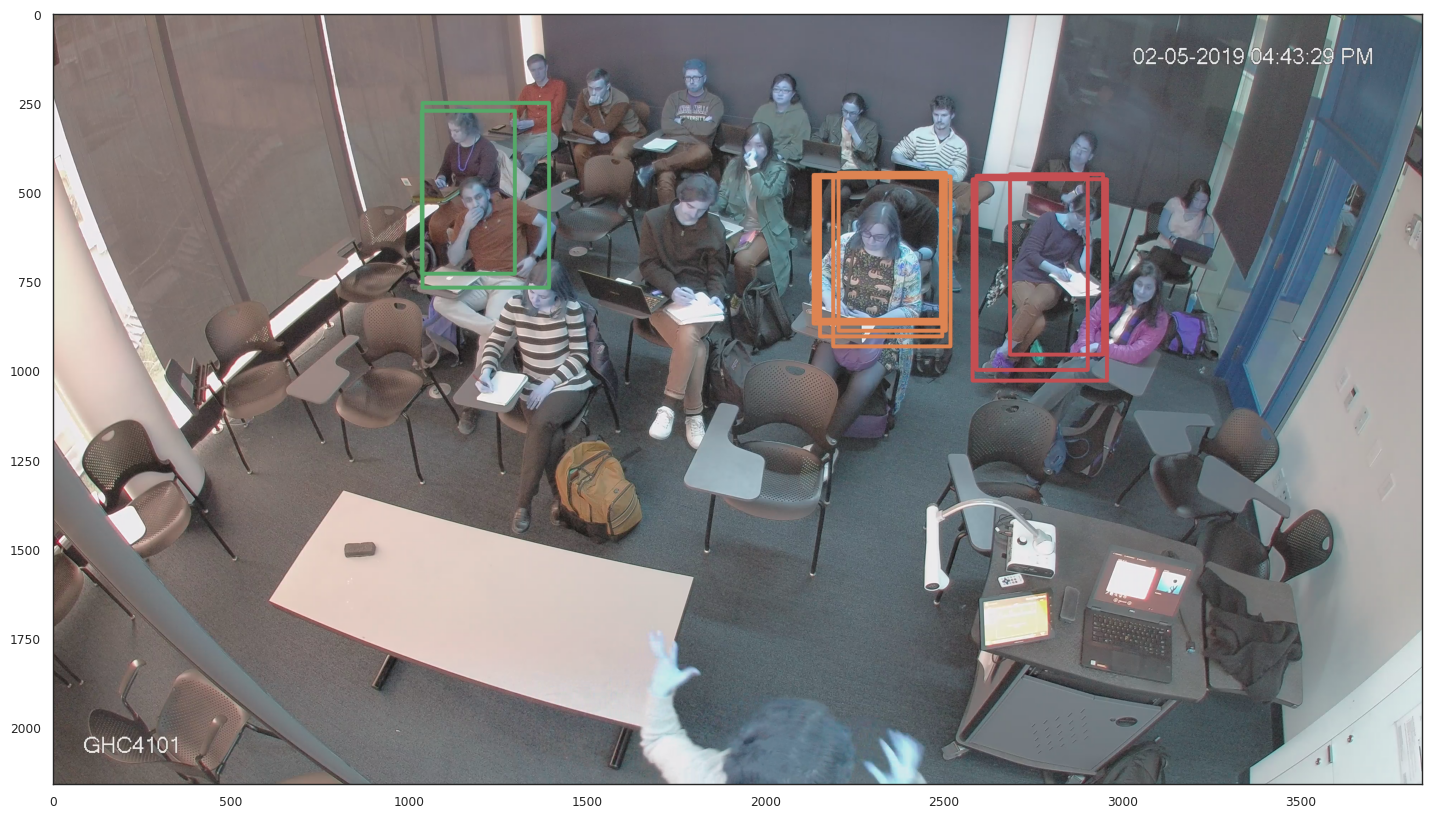

In [123]:
colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


# annotated_frame = cv2.cvtColor(deepcopy(frame_video), cv2.COLOR_BGR2RGB)
annotated_frame = deepcopy(frame_video)
prev_sid = 0
color_idx = 0
for idx, (sid1, sid2) in enumerate(manual_bboxes.keys()):
    if not (sid1==prev_sid):
        color_idx+=1
        X_TL1, Y_TL1, X_BR1, Y_BR1 = manual_bboxes[(sid1,sid2)][0]
    prev_sid=sid2
    X_TL2, Y_TL2, X_BR2, Y_BR2 = manual_bboxes[(sid1,sid2)][1]
    annotated_frame = cv2.rectangle(annotated_frame, (X_TL1, Y_TL1), (X_BR1, Y_BR1), hex_to_rgb(colors[color_idx]), 10)
    annotated_frame = cv2.rectangle(annotated_frame, (X_TL2, Y_TL2), (X_BR2, Y_BR2), hex_to_rgb(colors[color_idx]), 10)
    # plt.figure()
    # print(sid1, sid2)
    # plt.imshow(annotated_frame)

cv2.imwrite(f'case_studies/plots/annotated_space_frame_v2.jpg', annotated_frame)
plt.figure(figsize=(20,10))
plt.imshow(annotated_frame)

# Create Visualization from each session to collect id ground truth 

In [6]:
sample_course = '05748A'
sample_session_id = 'classinsight-cmu_05748A_ghc_4101_201902141630-front'
session_tracking_cache_file = f"{track_analysis_session_data}/{sample_session_id}.pb"
session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{sample_session_id}.pb"
session_frame_dir = f'{base_dir}/{sample_course}/{sample_session_id}'
session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{sample_session_id.split("-front")[0]}/{sample_session_id}.avi'
session_frame_dir

'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb_fixed_face/05748A/classinsight-cmu_05748A_ghc_4101_201902141630-front'

In [7]:
df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
total_idxs = df_tracking_new.index.max()
for old_id in old_to_new_id_map:
    new_id = old_to_new_id_map[old_id]
    if not new_id==10000:
        new_id_col = f'N{new_id}'
        if new_id_col not in df_tracking_new:
            df_tracking_new[new_id_col] = None
        df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
    df_tracking_new = df_tracking_new.drop(old_id, axis=1)


In [8]:
df_tracking_new.shape

(22553, 37)

In [9]:
total_idxs

67656

In [10]:
# old_to_new_id_map

In [11]:
col_start_stop_idxs = []
for col in df_tracking_new.columns:
    one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
    col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
df_id_start_stop

,id,min_idx,max_idx,total_idxs
0,0,0,67656,67656
1,1,0,67656,67656
2,2,60147,62745,2598
3,3,14067,53865,39798
4,4,0,67656,67656
5,5,0,67656,67656
6,6,40623,67656,27033
7,7,0,52224,52224
8,8,2583,67656,65073
9,9,62148,67656,5508


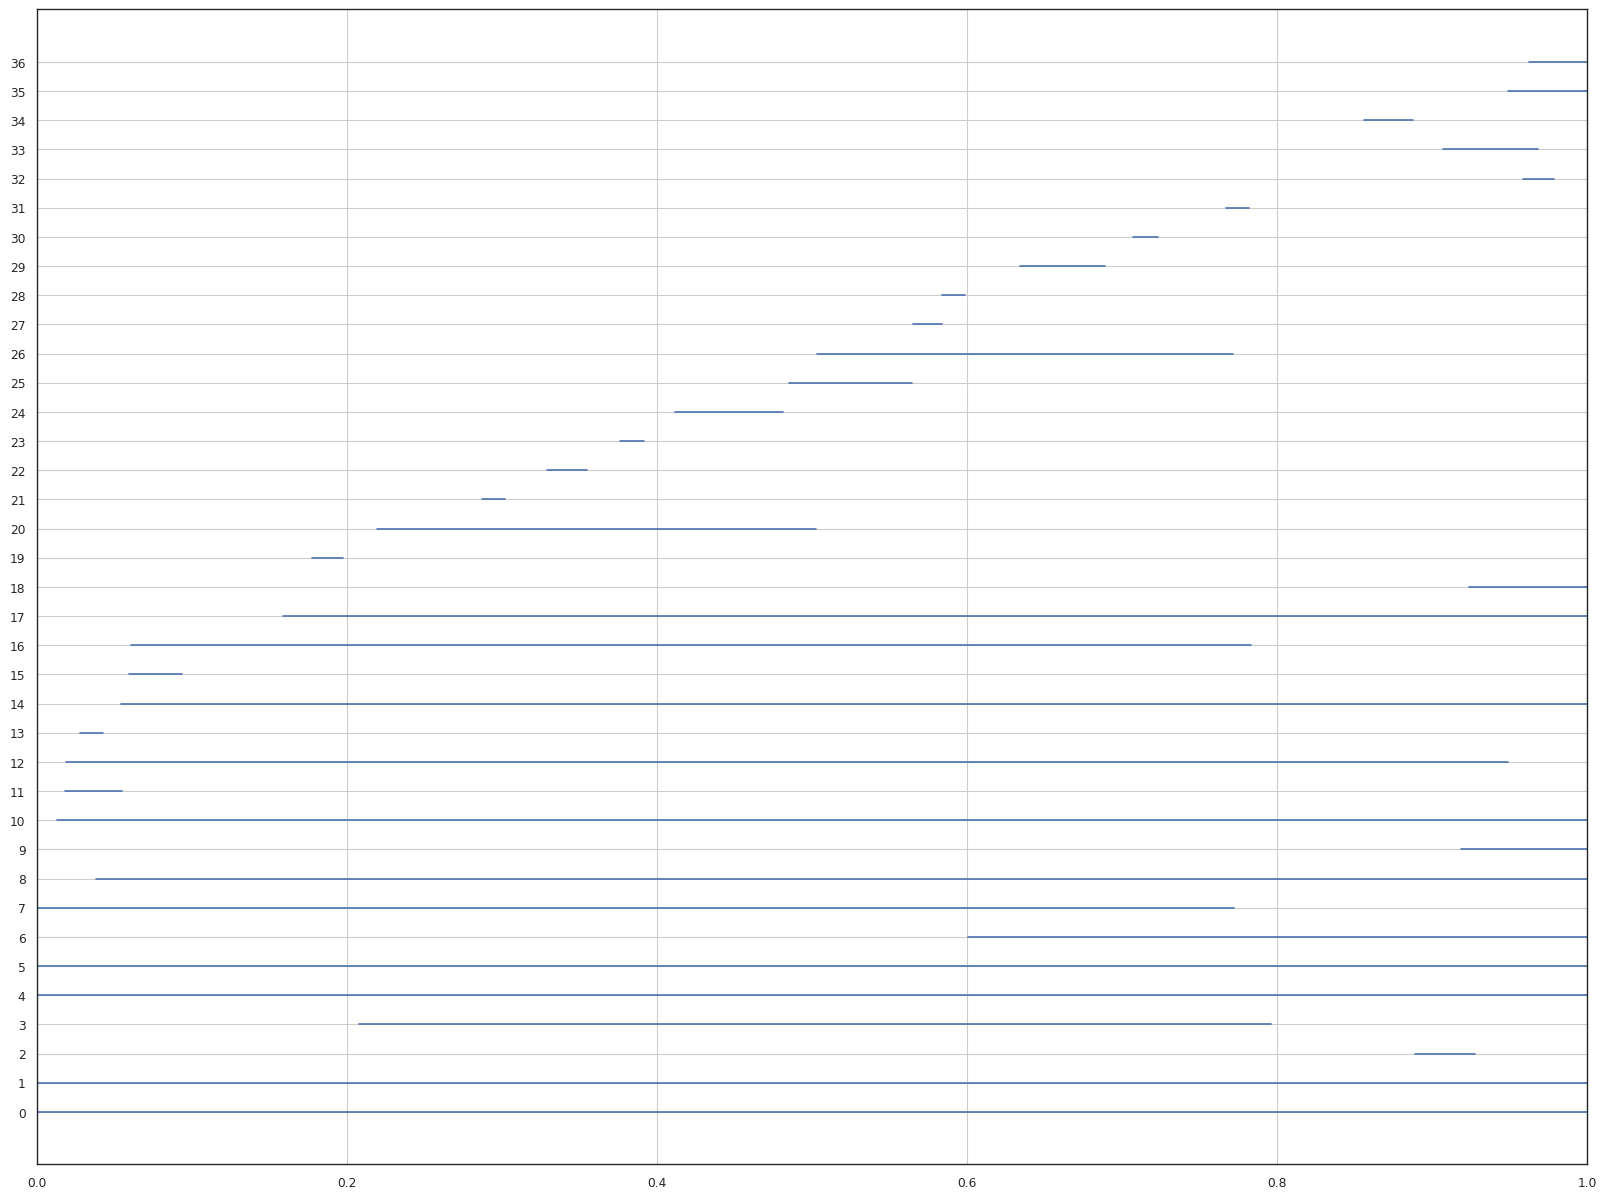

In [12]:
_ = plt.figure(figsize=(20,15))
for row_idx, row in df_id_start_stop.iterrows():
    plt.axhline(y=row_idx, xmin=row['min_idx']/total_idxs,xmax=row['max_idx']/total_idxs)
plt.yticks(range(df_id_start_stop.shape[0]), range(df_id_start_stop.shape[0]))
plt.grid() 

In [14]:
session_frames = df_tracking_new.index.values.tolist()
session_ids_covered = []
selected_frames = []
segments = []
segment_half_size = 50
for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
    id_start, id_stop = row['min_idx'],row['max_idx']
    seg_mid = (id_start+id_stop)/2
    seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
    is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
    seg_ids_covered = df_id_start_stop[is_id_covered]['id']
    new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
    if len(new_ids_covered)>0:        
        segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
        selected_frames+=segment_frames
        segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
        session_ids_covered+=new_ids_covered

sprint(segments)
    
    


List: segments


[
    (
        19868.5,
        19968.5,
        [0, 1, 3, 4, 5, 7, 8, 10, 12, 14, 16, 17, 20, 21],
        [
            19869,
            19872,
            19875,
            19878,
            19881,
            19884,
            19887,
            19890,
            19893,
            19896,
            19899,
            19902,
            19905,
            19908,
            19911,
            19914,
            19917,
            19920,
            19923,
            19926,
            19929,
            19932,
            19935,
            19938,
            19941,
            19944,
            19947,
            19950,
            19953,
            19956,
            19959,
            19962,
            19965,
            19968
        ]
    ),
    (
        39946.0,
        40046.0,
        [26, 28],
        [
            39948,
            39951,
            39954,
            39957,
            39960,
            39963,
            39966,
            39969,
            39972,
            39975,
            39978,
            39981,
            39984,
            39987,
            39990,
            39993,
            39996,
            39999,
            40002,
            40005,
            40008,
            40011,
            40014,
            40017,
            40020,
            40023,
            40026,
            40029,
            40032,
            40035,
            40038,
            40041,
            40044
        ]
    ),
    (
        52345.0,
        52445.0,
        [6, 31],
        [
            52347,
            52350,
            52353,
            52356,
            52359,
            52362,
            52365,
            52368,
            52371,
            52374,
            52377,
            52380,
            52383,
            52386,
            52389,
            52392,
            52395,
            52398,
            52401,
            52404,
            52407,
            52410,
            52413,
            52416,
            52419,
            52422,
            52425,
            52428,
            52431,
            52434,
            52437,
            52440,
            52443
        ]
    ),
    (
        2321.5,
        2421.5,
        [11, 13],
        [
            2322,
            2325,
            2328,
            2331,
            2334,
            2337,
            2340,
            2343,
            2346,
            2349,
            2352,
            2355,
            2358,
            2361,
            2364,
            2367,
            2370,
            2373,
            2376,
            2379,
            2382,
            2385,
            2388,
            2391,
            2394,
            2397,
            2400,
            2403,
            2406,
            2409,
            2412,
            2415,
            2418,
            2421
        ]
    ),
    (
        25909.0,
        26009.0,
        [23],
        [
            25911,
            25914,
            25917,
            25920,
            25923,
            25926,
            25929,
            25932,
            25935,
            25938,
            25941,
            25944,
            25947,
            25950,
            25953,
            25956,
            25959,
            25962,
            25965,
            25968,
            25971,
            25974,
            25977,
            25980,
            25983,
            25986,
            25989,
            25992,
            25995,
            25998,
            26001,
            26004,
            26007
        ]
    ),
    (
        48335.5,
        48435.5,
        [30],
        [
            48336,
            48339,
            48342,
            48345,
            48348,
            48351,
            48354,
            48357,
            48360,
            48363,
            48366,
            48369,
            48372,
            48375,
            48378,
            48381,
            48384,
            48387,

In [59]:
# for given frame ranges get video frames and tracking results
all_frames = mmcv.VideoReader(session_video_file)

required_frame_ids = np.unique(sorted(selected_frames))
frame_data_dict = {}

for frame_idx, frame_img in enumerate(all_frames):
    if (frame_idx in required_frame_ids) & (frame_idx%3==0):
        frame_data_dict[frame_idx] = frame_img
    if frame_idx%10000==0:
        print(f"Looped {frame_idx} images")
        



[h264 @ 0x1ab7847c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0xdc512c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc89f280] error while decoding MB 90 53, bytestream -9
[h264 @ 0xdc512c0] error while decoding MB 126 36, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 65 27, bytestream -9
[h264 @ 0xc89f280] error while decoding MB 90 53, bytestream -9


Looped 0 images


[h264 @ 0xe5dc400] error while decoding MB 71 30, bytestream -25
[h264 @ 0xc89f280] error while decoding MB 165 17, bytestream -8
[h264 @ 0xe5dc400] error while decoding MB 95 58, bytestream -5
[h264 @ 0x1b2d0b200] error while decoding MB 91 59, bytestream -7
[h264 @ 0x19e6eae80] error while decoding MB 90 33, bytestream -17
[h264 @ 0x18dff8280] error while decoding MB 159 18, bytestream -5
[h264 @ 0xc89f280] error while decoding MB 183 8, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 202 78, bytestream -9
[h264 @ 0x18ad04780] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x18ad04780] error while decoding MB 0 61, bytestream 358176
[h264 @ 0x192843780] error while decoding MB 166 124, bytestream -5
[h264 @ 0x18dff8280] error while decoding MB 46 54, bytestream -9
[h264 @ 0x1b2d0b200] error while decoding MB 194 101, bytestream -5
[h264 @ 0x192861c80] error while decoding MB 182 10, bytestream -7
[h264 @ 0xc89f280] error while decoding MB 90 73, bytestream -9


Looped 10000 images


[h264 @ 0x1aa5d2840] error while decoding MB 207 105, bytestream -11
[h264 @ 0xc89f280] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xc89f280] error while decoding MB 0 32, bytestream 460170
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 12 31
[h264 @ 0x1b2d0b200] error while decoding MB 12 31, bytestream 276481
[h264 @ 0xdc512c0] error while decoding MB 20 133, bytestream -9
[h264 @ 0x192843780] error while decoding MB 201 80, bytestream -5
[h264 @ 0xc8c6680] error while decoding MB 149 24, bytestream -5
[h264 @ 0xd86efc0] left block unavailable for requested intra4x4 mode -1
[h264 @ 0xd86efc0] error while decoding MB 0 35, bytestream 394977
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 219 27
[h264 @ 0x1b2d0b200] error while decoding MB 219 27, bytestream 381809
[h264 @ 0x192861c80] error while decoding MB 215 28, bytestream -5
[h264 @ 0x192843780] left block unavailable for requested intra mode
[h264 @ 0x192843780] error while decoding MB 0

Looped 20000 images


[h264 @ 0x192843780] cabac decode of qscale diff failed at 105 32
[h264 @ 0x192843780] error while decoding MB 105 32, bytestream 306418
[h264 @ 0xdc512c0] error while decoding MB 88 95, bytestream -5
[h264 @ 0x192861c80] cabac decode of qscale diff failed at 153 27
[h264 @ 0x192861c80] error while decoding MB 153 27, bytestream 423813
[h264 @ 0x19e6eae80] error while decoding MB 53 64, bytestream -7
[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 127 39
[h264 @ 0x1b2d0b200] error while decoding MB 127 39, bytestream 278642
[h264 @ 0xdc512c0] left block unavailable for requested intra mode
[h264 @ 0xdc512c0] error while decoding MB 0 28, bytestream 471725
[h264 @ 0x1aa7b2680] error while decoding MB 196 98, bytestream -7
[h264 @ 0x17eaaa640] left block unavailable for requested intra4x4 mode -1
[h264 @ 0x17eaaa640] error while decoding MB 0 30, bytestream 495453
[h264 @ 0x1aa7b2680] error while decoding MB 24 86, bytestream -5
[h264 @ 0x18ad04780] cabac decode of qscale diff

Looped 30000 images


[h264 @ 0x1b2d0b200] cabac decode of qscale diff failed at 44 46
[h264 @ 0x1b2d0b200] error while decoding MB 44 46, bytestream 304272
[h264 @ 0x18dff8280] error while decoding MB 46 71, bytestream -5
[h264 @ 0x19e6eae80] error while decoding MB 198 9, bytestream -5
[h264 @ 0x1aa5d2840] error while decoding MB 36 71, bytestream -5
[h264 @ 0x18dff8280] left block unavailable for requested intra mode
[h264 @ 0x18dff8280] error while decoding MB 0 42, bytestream 390394
[h264 @ 0x19d5e7280] cabac decode of qscale diff failed at 25 32
[h264 @ 0x19d5e7280] error while decoding MB 25 32, bytestream 349913
[h264 @ 0xc8c6680] error while decoding MB 117 76, bytestream -5
[h264 @ 0x192861c80] cabac decode of qscale diff failed at 219 31
[h264 @ 0x192861c80] error while decoding MB 219 31, bytestream 308676
[h264 @ 0xc8c6680] cabac decode of qscale diff failed at 115 36
[h264 @ 0xc8c6680] error while decoding MB 115 36, bytestream 434230
[h264 @ 0x18dff8280] cabac decode of qscale diff failed at 

Looped 40000 images


[h264 @ 0x1aa7b2680] error while decoding MB 87 36, bytestream -5
[h264 @ 0x18ad04780] left block unavailable for requested intra mode
[h264 @ 0x18ad04780] error while decoding MB 0 78, bytestream 247730
[h264 @ 0x192843780] error while decoding MB 51 130, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 3 93, bytestream -34
[h264 @ 0x1aa7b2680] error while decoding MB 201 123, bytestream -5
[h264 @ 0xd86efc0] error while decoding MB 46 49, bytestream -19
[h264 @ 0xc89f280] cabac decode of qscale diff failed at 226 62
[h264 @ 0xc89f280] error while decoding MB 226 62, bytestream 325152
[h264 @ 0xc89f280] error while decoding MB 195 116, bytestream -5
[h264 @ 0xc98f4c0] error while decoding MB 198 99, bytestream -7
[h264 @ 0xdc512c0] error while decoding MB 203 56, bytestream -5
[h264 @ 0xe5dc400] error while decoding MB 218 131, bytestream -12
[h264 @ 0x19d5e7280] error while decoding MB 203 114, bytestream -5
[h264 @ 0x1aa5d2840] error while decoding MB 190 51, bytestream -9
[

Looped 50000 images


[h264 @ 0xe5dc400] cabac decode of qscale diff failed at 203 34
[h264 @ 0xe5dc400] error while decoding MB 203 34, bytestream 232642
[h264 @ 0x17eaaa640] error while decoding MB 120 85, bytestream -5
[h264 @ 0x19e6eae80] left block unavailable for requested intra mode
[h264 @ 0x19e6eae80] error while decoding MB 0 123, bytestream 36075
[h264 @ 0x1aa7b2680] error while decoding MB 203 34, bytestream -15
[h264 @ 0xd86efc0] error while decoding MB 10 87, bytestream -5


Looped 60000 images


[h264 @ 0x1aa5d2840] cabac decode of qscale diff failed at 182 38
[h264 @ 0x1aa5d2840] error while decoding MB 182 38, bytestream 366798
[h264 @ 0x19e6eae80] error while decoding MB 68 57, bytestream -9
[h264 @ 0xc8c6680] error while decoding MB 196 46, bytestream -9
[h264 @ 0xd86efc0] cabac decode of qscale diff failed at 229 24
[h264 @ 0xd86efc0] error while decoding MB 229 24, bytestream 316154
[h264 @ 0x1aa7b2680] cabac decode of qscale diff failed at 80 95
[h264 @ 0x1aa7b2680] error while decoding MB 80 95, bytestream 96365
[h264 @ 0xd86efc0] error while decoding MB 27 64, bytestream -9


Looped 70000 images


In [1]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}


In [61]:
len(frame_data_dict.keys())

535

In [62]:
session_id_viz_dir = f'{id_viz_cache_root}/{sample_session_id}'
os.makedirs(session_id_viz_dir, exist_ok=True)


In [63]:
if tracking_model:
    printm("# Deleting Previous Model")
    del tracking_model
tracking_model = init_tracking_model(run_config['track_config'],
                                 run_config['track_checkpoint'],
                                 device=run_config['device'])
for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
    seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
    match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
    match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
    if os.path.exists(match_video_file):
        continue
    print(match_video_file)
    os.makedirs(match_cache_dir, exist_ok=True)
    frame_num=0

    for frame_idx in segment_frames:
        frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
        if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
            frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
            frame_num+=1
            if os.path.exists(frame_file_out):
                continue
            frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
            for person_idx in range(len(frame_tracking_results)):
                old_id= int(frame_tracking_results[person_idx]['track_id'])
                frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
            frame_img = deepcopy(frame_data_dict[frame_idx])
            if len(frame_tracking_results)>0:
                frame_tracking_results = {
                    'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                    'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                frame_track_img = tracking_model.show_result(
                    frame_img,
                    frame_tracking_results,
                    thickness=5,
                    font_scale=.5,
                    score_thr=0.1,
                    show=False,
                    wait_time=int(1000. / 5),
                    out_file=frame_file_out,
                    backend='cv2')
            else:
                cv2.imwrite(frame_file_out,frame_img)
    
    #         break
    # break
    mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
    print(f"Done for segment {seg_video_id}")
    # break
    
    

# Deleting Previous Model

2023-08-11 16:16:16,104 - mmdet - INFO - image shape: height=800, width=1440 in YOLOX.__init__
2023-08-11 16:16:16,263 - mmtrack - INFO - initialize YOLOX with init_cfg {'type': 'Pretrained', 'checkpoint': 'https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth'}
2023-08-11 16:16:16,264 - mmcv - INFO - load model from: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-08-11 16:16:16,264 - mmcv - INFO - load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
2023-08-11 16:16:18,331 - mmcv - WARNING - The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 320, 1, 1]) from checkpoint, the shape in current model is torch.Size([1, 320, 1, 

load checkpoint from local path: /home/prasoon/video_analysis/edusenseV2compute/compute/videoV3/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_detector_backbone_stem_conv_conv_weight, ema_detector_backbone_stem_conv_bn_weight, ema_detector_backbone_stem_conv_bn_bias, ema_detector_backbone_stem_conv_bn_running_mean, ema_detector_backbone_stem_conv_bn_running_var, ema_detector_backbone_stem_conv_bn_num_batches_tracked, ema_detector_backbone_stage1_0_conv_weight, ema_detector_backbone_stage1_0_bn_weight, ema_detector_backbone_stage1_0_bn_bias, ema_detector_backbone_stage1_0_bn_running_mean, ema_detector_backbone_stage1_0_bn_running_var, ema_detector_backbone_stage1_0_bn_num_batches_tracked, ema_detector_backbone_stage1_1_main_conv_conv_weight, ema_detector_backbone_stage1_1_main_conv_bn_weight, ema_detector_backbone_stage1_1_main_conv_bn_bias, ema_detector

In [65]:
id_viz_cache_root

'/mnt/ci-nas-cache/edulyzeV2/cache_compute_4//analysis_tracking/session_matching_info'

# Run visualization code on all sessions

In [ ]:
SOURCE_ROOT = '/home/prasoon/video_analysis/edusenseV2compute/compute/videoV3'
run_config = {
    'track_config':f'{SOURCE_ROOT}/configs/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half.py',
    'track_checkpoint':f'{SOURCE_ROOT}/models/mmlab/ocsort_yolox_x_crowdhuman_mot17-private-half_20220813_101618-fe150582.pth',
    'device':'cuda:1',
}

for course_idx, course in enumerate(frame_file_data):
    for session_idx, session_id in enumerate(frame_file_data[course]):
        session_id_viz_dir = f'{id_viz_cache_root}/{session_id}'
        if not os.path.exists(session_id_viz_dir):
            
            session_tracking_cache_file = f"{track_analysis_session_data}/{session_id}.pb"
            session_preprocessed_id_map_file = f"{postprocessed_id_map_data_dir}/{session_id}.pb"
            session_frame_dir = f'/mnt/ci-nas-cache/edulyzeV2/pose_face_gaze_emb/{course}/{session_id}'
            session_video_file = f'/mnt/ci-nas-classes/classinsight/2019S/video_backup/{session_id.split("-front")[0]}/{session_id}.avi'
            printm(f'# {course_idx}-{course}, session:{session_idx}-{session_id}')
            printm("## Get preprocessed tracking ids...")
            
            df_tracking_new = pickle.load(open(session_tracking_cache_file,"rb")).transpose()
            old_to_new_id_map = pickle.load(open(session_preprocessed_id_map_file,"rb"))
            total_idxs = df_tracking_new.index.max()
            for old_id in old_to_new_id_map:
                new_id = old_to_new_id_map[old_id]
                if not new_id==10000:
                    new_id_col = f'N{new_id}'
                    if new_id_col not in df_tracking_new:
                        df_tracking_new[new_id_col] = None
                    df_tracking_new[new_id_col] =  df_tracking_new[old_id].where(~df_tracking_new[old_id].isnull(), df_tracking_new[old_id])
                df_tracking_new = df_tracking_new.drop(old_id, axis=1)

            col_start_stop_idxs = []
            for col in df_tracking_new.columns:
                one_idxs = df_tracking_new.index[np.where(df_tracking_new[col]==1)[0]].values
                col_start_stop_idxs.append([col, one_idxs.min(), one_idxs.max()])
            df_id_start_stop = pd.DataFrame(col_start_stop_idxs, columns=['id','min_idx','max_idx'])
            df_id_start_stop['total_idxs'] = df_id_start_stop['max_idx']-df_id_start_stop['min_idx']
            df_id_start_stop['id'] = df_id_start_stop['id'].apply(lambda x: int(x[1:]))
            
            printm(f"## Get segments to visualize from {df_tracking_new.shape[1]} tracking ids...")
            session_frames = df_tracking_new.index.values.tolist()
            session_ids_covered = []
            selected_frames = []
            segments = []
            segment_half_size = 50
            for row_idx, row in df_id_start_stop.sort_values(by='total_idxs').iterrows():
                id_start, id_stop = row['min_idx'],row['max_idx']
                seg_mid = (id_start+id_stop)/2
                seg_start, seg_end = max(seg_mid-segment_half_size, 0), min(seg_mid+segment_half_size, total_idxs)
                is_id_covered = df_id_start_stop.apply(lambda row: (seg_end<=row['max_idx']) & (seg_start>=row['min_idx']),axis=1)
                seg_ids_covered = df_id_start_stop[is_id_covered]['id']
                new_ids_covered = [xr for xr in seg_ids_covered if xr not in session_ids_covered]
                if len(new_ids_covered)>0:        
                    segment_frames = [xr for xr in session_frames if ((xr>=seg_start) and (xr<=seg_end))]
                    selected_frames+=segment_frames
                    segments.append((seg_start, seg_end, new_ids_covered, segment_frames))
                    session_ids_covered+=new_ids_covered
            printm(f"## Got {len(segments)} segments to visualize...")

            printm(f"## Get video frames from session video file for segment frames...")
            all_frames = mmcv.VideoReader(session_video_file)
            required_frame_ids = np.unique(sorted(selected_frames))
            frame_data_dict = dict()
            
            for frame_idx, frame_img in enumerate(all_frames):
                if (frame_idx in required_frame_ids) & (frame_idx%3==0):
                    frame_data_dict[frame_idx] = frame_img
                if frame_idx%1000==0:
                    print(f"Looped {frame_idx} images")
            printm(f"## Got {len(frame_data_dict.keys())} video frames from session video file...")

            printm(f"## Create segment videos with new tracking ids...")
            os.makedirs(session_id_viz_dir, exist_ok=True)
            tracking_model = init_tracking_model(run_config['track_config'],
                                             run_config['track_checkpoint'],
                                             device=run_config['device'])
            for seg_idx, (seg_start, seg_end, new_ids_covered, segment_frames) in enumerate(segments):
                seg_video_id = f'S{seg_idx}_{int(seg_start)}_{int(seg_end)}_{"_".join(map(str,new_ids_covered))}'
                match_cache_dir = f'{session_id_viz_dir}/{seg_video_id}'
                match_video_file = f'{session_id_viz_dir}/{seg_video_id}.mp4'
                if os.path.exists(match_video_file):
                    continue
                print(match_video_file)
                os.makedirs(match_cache_dir, exist_ok=True)
                frame_num=0
            
                for frame_idx in segment_frames:
                    frame_tracking_file = f"{session_frame_dir}/{frame_idx}.pb"
                    if os.path.exists(frame_tracking_file) and (frame_idx in frame_data_dict):
                        frame_file_out = os.path.join(match_cache_dir, f'{frame_num:06d}.jpg')
                        frame_num+=1
                        if os.path.exists(frame_file_out):
                            continue
                        frame_tracking_results = pickle.load(open(frame_tracking_file,"rb"))[1]
                        for person_idx in range(len(frame_tracking_results)):
                            old_id= int(frame_tracking_results[person_idx]['track_id'])
                            frame_tracking_results[person_idx]['track_id'] =old_to_new_id_map[old_id]
                        frame_img = deepcopy(frame_data_dict[frame_idx])
                        if len(frame_tracking_results)>0:
                            frame_tracking_results = {
                                'track_bboxes':[np.array([[xr['track_id']]+xr['bbox'].tolist() for xr in frame_tracking_results])],
                                'det_bboxes':[np.array([xr['bbox'].tolist() for xr in frame_tracking_results])]}
                            frame_track_img = tracking_model.show_result(
                                frame_img,
                                frame_tracking_results,
                                thickness=5,
                                font_scale=.5,
                                score_thr=0.1,
                                show=False,
                                wait_time=int(1000. / 5),
                                out_file=frame_file_out,
                                backend='cv2')
                        else:
                            cv2.imwrite(frame_file_out,frame_img)
                mmcv.frames2video(match_cache_dir, match_video_file, fps=5, fourcc='mp4v')
                print(f"Done for segment {seg_video_id}")
            del tracking_model
            printm(f"## Created Segment Visualization for session: {course_idx}-{course}, session:{session_idx}-{session_id} from {len(old_to_new_id_map.keys())} to {df_id_start_stop.shape[0]} ids")
        else:
            printm(f"## Segement visualization directory EXISTS for session: {course_idx}-{course}, session:{session_idx}-{session_id}")
            
        
        

# 0-05410A, session:0-classinsight-cmu_05410A_ghc_4301_201902181500-front

## Get preprocessed tracking ids...

In [6]:
session_video_file

'/mnt/ci-nas-classes/classinsight/2019S/video_backup/classinsight-cmu_05410A_ghc_4301_201902251500/classinsight-cmu_05410A_ghc_4301_201902251500-front.avi'